# Hi, human!

## Why this dataset?
To determine which subjects politicians or organisations lie about most frequently, this dataset is quite intriguing. Analyze the connection between their political influence and the remarks they make.

## What questions will I be answering?
1. Display the 15 politicians who appeared in the dataset the most
2. What topics are the most spicular? 
3. Which politicians lied the most?
4. What are the most common words politicians say in speeches?
5. Find out which politician lied most about what topic.


## Dataset Summary
LIAR is a dataset for fake news detection with 12.8K human labeled short statements from politifact.com's API, and each statement is evaluated by a politifact.com editor for its truthfulness. The distribution of labels in the LIAR dataset is relatively well-balanced: except for 1,050 pants-fire cases, the instances for all other labels range from 2,063 to 2,638. In each case, the labeler provides a lengthy analysis report to ground each judgment.

## LABELS 
| Label ID | State         |
|---|---------------|
| 0 | False         |
| 1 | Half-true     |
| 2 | Mostly-true   |
| 3 | True          |
| 4 | Barely-True   |
| 5 | Pants-on-fire |

In [28]:
!pip install wordcloud

In [29]:
!pip install datasets

In [30]:
from datasets import load_dataset
liar_dataset = load_dataset("liar")
liar_dataset
print(f'Dataset size is {liar_dataset["train"].dataset_size}')
print(f'Dataset description: {liar_dataset["train"].description}')
print(f'Features: {liar_dataset["train"].features}')

Found cached dataset liar (/Users/belochenko/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514)


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset size is 3413529
Dataset description: LIAR is a dataset for fake news detection with 12.8K human labeled short statements from politifact.com's API, and each statement is evaluated by a politifact.com editor for its truthfulness. The distribution of labels in the LIAR dataset is relatively well-balanced: except for 1,050 pants-fire cases, the instances for all other labels range from 2,063 to 2,638. In each case, the labeler provides a lengthy analysis report to ground each judgment.

Features: {'id': Value(dtype='string', id=None), 'label': ClassLabel(names=['false', 'half-true', 'mostly-true', 'true', 'barely-true', 'pants-fire'], id=None), 'statement': Value(dtype='string', id=None), 'subject': Value(dtype='string', id=None), 'speaker': Value(dtype='string', id=None), 'job_title': Value(dtype='string', id=None), 'state_info': Value(dtype='string', id=None), 'party_affiliation': Value(dtype='string', id=None), 'barely_true_counts': Value(dtype='float32', id=None), 'false_count

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/belochenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/belochenko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/belochenko/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/belochenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Extraction and Cleaning
#### Make a preliminary analysis of the data 

In [32]:
data = pd.DataFrame(liar_dataset['train'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10269 entries, 0 to 10268
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10269 non-null  object 
 1   label                 10269 non-null  int64  
 2   statement             10269 non-null  object 
 3   subject               10269 non-null  object 
 4   speaker               10269 non-null  object 
 5   job_title             10269 non-null  object 
 6   state_info            10269 non-null  object 
 7   party_affiliation     10269 non-null  object 
 8   barely_true_counts    10269 non-null  float64
 9   false_counts          10269 non-null  float64
 10  half_true_counts      10269 non-null  float64
 11  mostly_true_counts    10269 non-null  float64
 12  pants_on_fire_counts  10269 non-null  float64
 13  context               10269 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 1.1+ MB


In [33]:
data.shape # Find out the shape of dataset

(10269, 14)

In [34]:
data.head(10) # Display first 10 rows

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,0,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
5,12465.json,3,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece
6,2342.json,4,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.
7,153.json,1,"""I'm the only person on this stage who has wor...",ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa."
8,5602.json,1,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,,,organization,0.0,0.0,1.0,0.0,1.0,a website
9,9741.json,2,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video


#### Let's delete the following columns, because they do not have any meaning in the context of this problem 

In [35]:
data = data.drop(columns=['id','context', 'barely_true_counts',	'false_counts',	'half_true_counts',	'mostly_true_counts',	'pants_on_fire_counts'])

#### Сheck if there are null values and duplicatesvalues

In [36]:
# Find the duplicates
data.duplicated().sum()

2

In [37]:
# Drop duplicate reviews
data.drop_duplicates(inplace = True)

In [38]:
# Discover the Null values
data.isnull().sum()

label                0
statement            0
subject              0
speaker              0
job_title            0
state_info           0
party_affiliation    0
dtype: int64

### Display the 15 politicians who appeared in the dataset the most

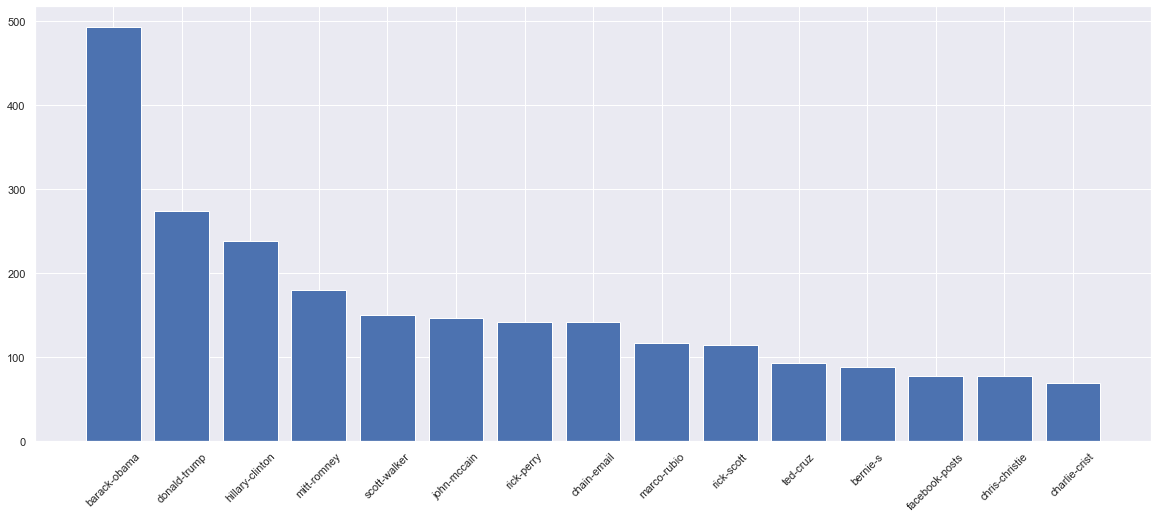

In [39]:
top_speakers = data['speaker'].value_counts()[:15]
plt.figure(figsize=(20,8))
plt.bar(top_speakers.keys(), top_speakers.values)
plt.xticks(rotation=45);

## What topics are the most spicular?
Let's limit our sample to only those claims that have been classified as False and Half-True in order to maintain the experiment's integrity.

In [40]:
false_and_half_true = data.loc[(data['label'] == 0) | (data['label'] == 1)] # Where 0 is False and 1 is Half-True

In [41]:
subjects = [val for sub in false_and_half_true['subject'] for val in sub.split(',')] # Using list comp. create list of all subject that appear in subject column and also splited with comma

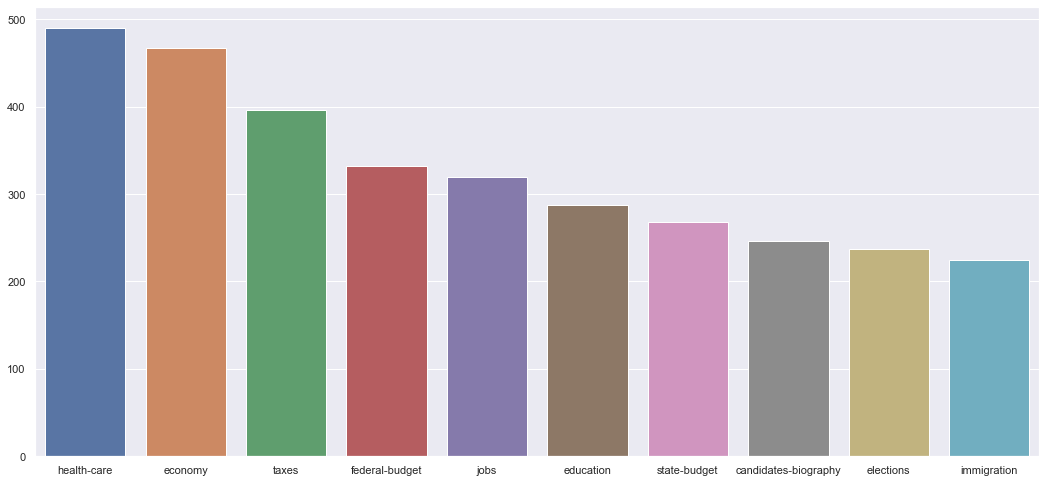

In [42]:
counter = Counter(subjects)
most = counter.most_common(10)

topics_names = [row[0] for row in most] 

topics_count = [row[1] for row in most]

sns.set(rc={'figure.figsize':(18,8.27)})
sns.barplot(x=topics_names, y=topics_count);

## What are the most common words politicians say in speeches?

#### Remove stop words

In [43]:
stop_words = set(stopwords.words('english'))

filtering_statement = data['statement'].str.split()
list_word_sentence = filtering_statement.values.tolist()
filtered_sentence = [val for w in list_word_sentence for val in w if not val.lower() in stop_words]

#### Perfrom lemmatization

In [44]:
lem = WordNetLemmatizer()
text_lemmatized = [lem.lemmatize(y) for y in filtered_sentence] 
text_lemmatized;

#### Perform Stemming

In [45]:
stemmer = PorterStemmer() 
text_stemmed = [stemmer.stem(y) for y in filtered_sentence]
text_stemmed;

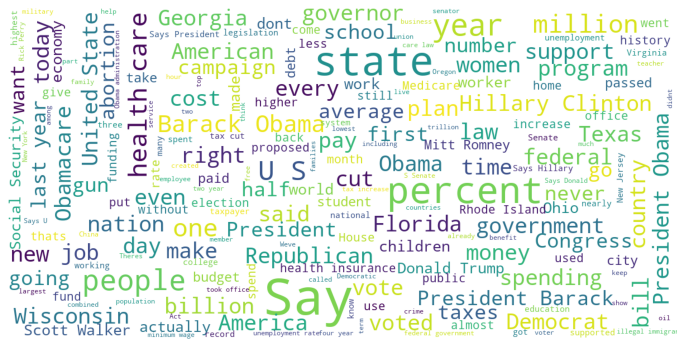

In [46]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=30,
        scale=3,
        random_state=1
        ).generate(' '.join(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(filtered_sentence)

### Let's analyze which which politicians are giving speeches that contain entirely false material
#### 0 implies that the speaker was telling an absolute lie

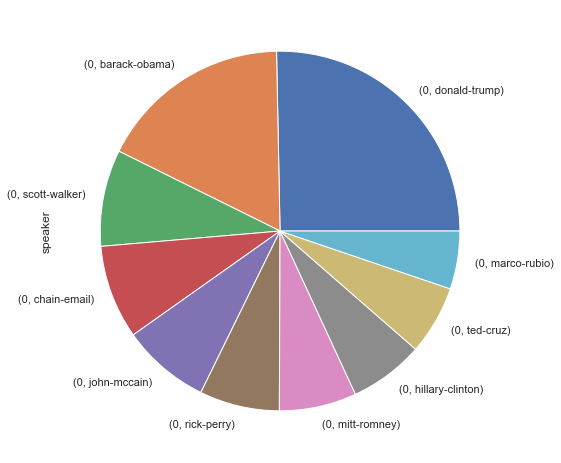

In [47]:
false_and_half_true.groupby('label')['speaker'].value_counts()[:10].plot(kind='pie');

### Find out which politician lied most about what topic.
#### Create pie charts showing which topics the four politicians lied about the most.

In [48]:
import collections

speaker_topic_map = {}
for subject_names, speaker_name in zip(false_and_half_true['subject'], false_and_half_true['speaker']):
    parsed_topic = subject_names.split(",") # Different topics may have been raised in the same speech, so they are separated in the dataset by a comma

    if speaker_name in speaker_topic_map:
        speaker_topic_map[speaker_name].append(parsed_topic)
    else:
        speaker_topic_map[speaker_name] = [sub for sub in parsed_topic] # Unpack the topic list, if any


# Function of irregular list normalization (alignment)
flatten = lambda *n: (e for a in n
    for e in (flatten(*a) 
    if isinstance(a, (tuple, list)) else (a,))) 


for name, list_of_subjects in speaker_topic_map.items():
    speaker_topic_map[name] = Counter(flatten(list_of_subjects)) # Apply Counter to count the number of times a speaker has raised a topics

# For convenience, let's sort the dictionary in descending order, where the sorting key is the sum of the values of the topics mentioned
sorted_parsed_topic_map = sorted(speaker_topic_map.items(), key=lambda x: sum(x[1].values()), reverse=True)

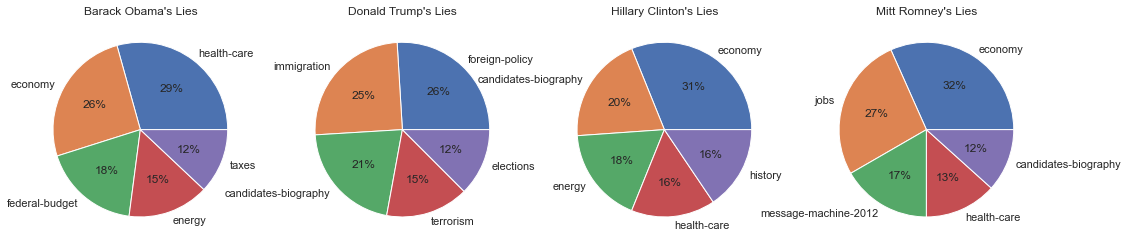

In [49]:
# Some const
NUMBER_OF_TOPS = 4
NUMBER_MOST_COMMON_TOPICS = 5 # For ease of display, let's take only the N (N<10) most false topics of the speaker

fig, axes = plt.subplots(1, NUMBER_OF_TOPS) # Create four graphs

for idx, tuple_speaker_topics in enumerate(sorted_parsed_topic_map[:NUMBER_OF_TOPS]):
    n_topic_pair = tuple_speaker_topics[1].most_common(NUMBER_MOST_COMMON_TOPICS) 
    pair_values = [val[1] for val in n_topic_pair]
    pair_labels = [val[0] for val in n_topic_pair]

    axes[idx].pie(pair_values, labels = pair_labels, autopct='%1.0f%%')
    axes[idx].set_title(f"{tuple_speaker_topics[0].replace('-',' ').title()}'s Lies", fontsize = 12)

plt.show()
